<a href="https://colab.research.google.com/github/IT21388934/code_emberding_using_codeBERT/blob/main/gradingModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn pandas transformers


In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load the pre-trained CodeBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [5]:
# Function to get embeddings for Java cod
def get_code_embedding(code):
    # Move input to the same device as the model
    inputs = tokenizer(code, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU after computation
    return embeddings.flatten()

In [6]:
url = '/content/drive/MyDrive/AI_ML/projectModel/model2/java_code_submissions_large_new.csv'
data = pd.read_csv(url)


# Print the total number of rows (data entries)
print("Total number of data entries (rows):", data.shape[0])



Total number of data entries (rows): 10000


In [7]:
# Generate embeddings for the dataset
data['code_embedding'] = data['code'].apply(lambda x: get_code_embedding(x))

# Check if the embeddings have consistent lengths
embedding_lengths = data['code_embedding'].apply(lambda x: len(x))
print(embedding_lengths.value_counts())  # Ensure consistent length of embeddings

# Find the maximum length of the embeddings
max_len = max(data['code_embedding'].apply(len))

# Pad or truncate each embedding to have the same length
X = np.array([np.pad(embedding, (0, max_len - len(embedding))) if len(embedding) < max_len else embedding[:max_len] for embedding in data['code_embedding']])

# Check the shape of X
print("Shape of X:", X.shape)

# Prepare features (X) and labels (y)
y = data['grade']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Regressor on the training set
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Validate the model on the testing set
y_pred = model.predict(X_test)
print("MSE (Test Data):", mean_squared_error(y_test, y_pred))

code_embedding
768    10000
Name: count, dtype: int64
Shape of X: (10000, 768)
MSE (Test Data): 880.5703849717593


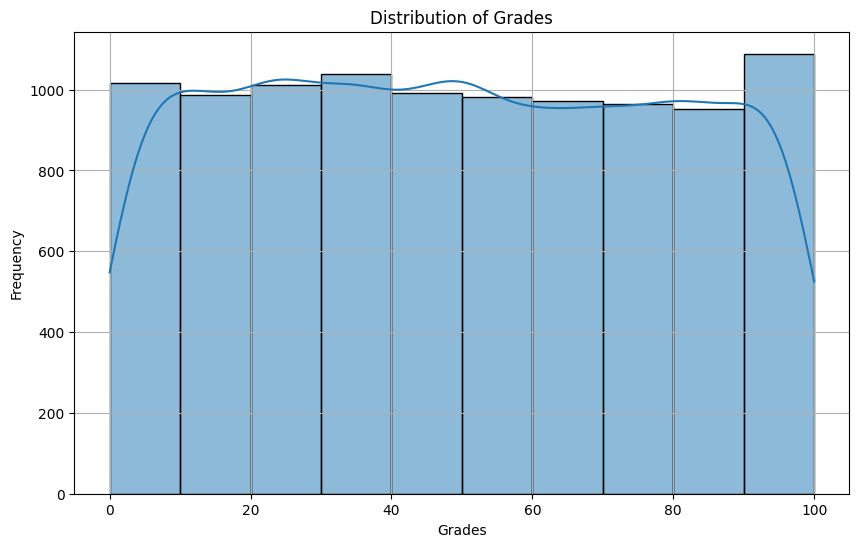

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of grades
plt.figure(figsize=(10, 6))
sns.histplot(data['grade'], bins=10, kde=True)
plt.title('Distribution of Grades')
plt.xlabel('Grades')
plt.ylabel('Frequency')
plt.grid()
plt.show()


R-squared (Test Data): 2.1293731064853105e-05


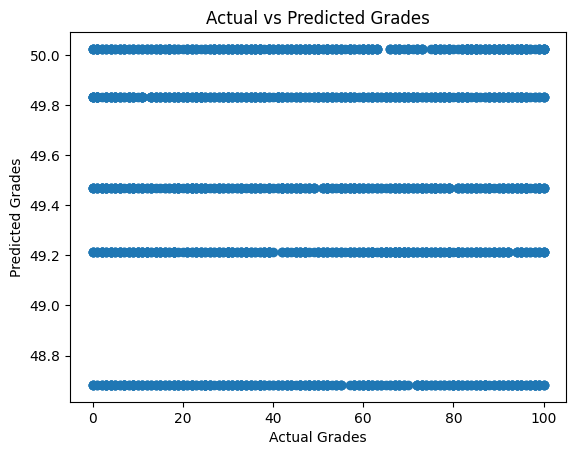

In [9]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared (Test Data):", r2)

# Plot actual vs predicted grades
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Grades")
plt.ylabel("Predicted Grades")
plt.title("Actual vs Predicted Grades")
plt.show()


In [10]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation MSE:", -cv_scores.mean())


Cross-Validation MSE: 849.0438824625568
